# Introduction

We analysze the Boston housing dataset as a first benchmark for our aggregation task. We will train a few standard Machine Learning (ML) models, before aggregating them and analyzing the results. 

## The Boston Housing dataset

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

1. CRIM - per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 doller
11. PTRATIO: pupil-teacher ratio by town 
12. B: (1000(Bk−0.63)2) where Bk is the proportion of blacks by  
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000 doller


## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import Matern
from functools import partial
import torch
import torch.optim as optim
from typing import OrderedDict
from tqdm import tqdm

In [2]:
np.random.seed(0)

## Loading the Data

In [3]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = df.loc[:,features]
y = df['MEDV']

In [6]:
#normalize features
X = (X - X.mean()) / X.std()

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
indices=range(len(X_train))
X_train_reduced, X_val, y_train_reduced, y_val,indices_train_reduced,indices_val = train_test_split(X_train, y_train,indices, test_size=0.1, random_state=4)

## Model training

We train benchmark models, i.e. models trained on validation and training data. Our aggregation should beat them, as it has seen the same amount of data as models trained on training and validation set. 

In [8]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

In [9]:
# Define a dictionary to store the model performances
performances = {}

# Train the models and evaluate their performances
for model, name in zip(models, model_names):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances[name] = [mae, mse, r2]

# Aggregation

We will train a GP to aggregate the models, and two Neural Networks. For a fair comparison, we also train new models on only the training set, while the aggregation will use validation data. 

In [10]:
models_reduced=[LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]
model_number=len(models_reduced)
models_reduced=[m.fit(X_train_reduced.to_numpy(),y_train_reduced.to_numpy()) for m in models_reduced]
def as_func(model,x):
    return model.predict(x)
models_reduced=[partial(as_func,m) for m in models_reduced]

In [11]:
# Define a dictionary to store the model performances
performances_reduced = {}

# Train the models and evaluate their performances
for model, name in zip(models_reduced, model_names):
    # Make predictions on the test set
    y_pred = model(X_test.to_numpy())
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances_reduced[name] = [mae, mse, r2]

## For comparison, compute the performance of averaging the models

In [12]:
model_pred_test=[m(X_test.to_numpy()) for m in models_reduced]
mean_pred=np.mean(model_pred_test,axis=0)
mae = mean_absolute_error(y_test, mean_pred)
mse = mean_squared_error(y_test, mean_pred)
r2 = r2_score(y_test, mean_pred)

# Store the performance metrics in the dictionary
performances['mean'] = [mae, mse, r2]

## GP Aggregation

### Define the kernel

Recall the Matern kernel with $\nu=3/2$

$$Matern(x, y) = \left(1 + \frac{\sqrt{3}\lVert x-y\rVert}{\rho}\right) \exp\left(-\frac{\sqrt{3}\lVert x-y\rVert}{\rho}\right)$$

Where $\lVert x\rVert=\sqrt{\sum_{i=1}^nx_i^2}$ is the euclidean distance, and $\rho$ is the lengthscale. We use the sum of two Matern kernels. One Matern kernel applied to the input, and one applied to the outputs of the models. We define $x$ as a row of our data, and $M(x)\in\mathbb{R}^6$ the stacked predictions of our models. Our kernel is 
$$k(x,y)=Matern(x,y)+Matern(M(x),M(y))$$

In [13]:
def OnModels(x,y):
    Mx=np.stack([m(x) for m in models_reduced],axis=-1)
    My=np.stack([m(y) for m in models_reduced],axis=-1)
    return matern_models(Mx,My)

def add_kernel(x,y,k1,k2):
    if y is None:
        y=x
    return k1(x,y)+k2(x,y)


matern=Matern(length_scale=0.5,nu=1.5)
y_lengthscale=np.mean(np.abs(y_train.to_numpy()[:,None]-y_train.to_numpy()[None,:]))
matern_models=Matern(length_scale=y_lengthscale/2,nu=1.5)



k=partial(add_kernel,k1=OnModels,k2=matern)

We now evaluate this kernel on our dataset and set up fitting the GP

In [14]:


K_mat=k(X_val.to_numpy(),X_val.to_numpy())
errors=(y_val.to_numpy()[:,None]-np.stack([m(X_val.to_numpy()) for m in models_reduced],axis=-1))**2
K_mat=torch.tensor(K_mat,dtype=torch.float32)
errors=torch.tensor(errors,dtype=torch.float32)

To fit the GP, we use Pytorch's optimization package. We try both gradient descent and Newton's method. 

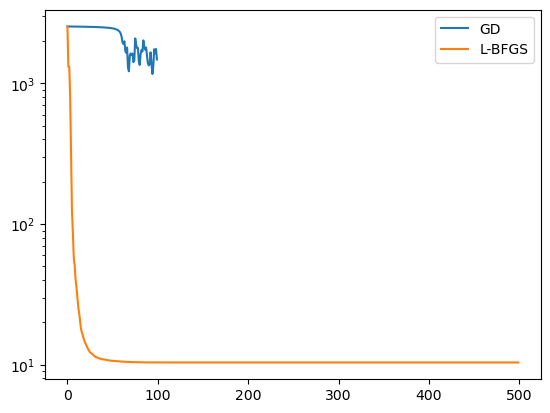

In [15]:
lam=1e-1
def loss_fn(V):
    pred = torch.matmul(K_mat, V[:-1])+V[-1:]
    return torch.mean((torch.exp(pred)-errors)**2)+lam*torch.sum(V[:-1]**2)


# Gradient Descent
V0=torch.zeros(errors.shape[0]+1,errors.shape[1])
V0.requires_grad=True
gd = optim.SGD([V0], lr=1e-3)
history_gd = []
for i in range(100):
    gd.zero_grad()
    objective = loss_fn(V0)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())


# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = loss_fn(V1)
    objective.backward()
    return objective

V1=torch.zeros(errors.shape[0]+1,errors.shape[1])
V1.requires_grad=True

lbfgs = optim.LBFGS([V1],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")
                    
history_lbfgs = []
for i in range(500):
    history_lbfgs.append(loss_fn(V1).item())
    lbfgs.step(closure)


# Plotting
plt.semilogy(history_gd, label='GD')
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.legend()
plt.show()

We define the `GPAggregator` class to store the result of the optimisation and perform the aggregation

In [16]:
class GPAggregator:
    def __init__(self, kernel, model_caller, mean=True):
        self.mean = mean
        self.model_caller = model_caller
        self.kernel=kernel

    @property
    def model_number(self):
        return self.coefficients.shape[1]

    def GP_predict(self, x):
        """gives the prediction of the GP.
        output has shape (n, n_model) where n is the number of data points"""
        kernel_matrix = self.kernel(x, self.X)
        if hasattr(self, "kernel"):
            return kernel_matrix @ self.coefficients + self.mean_log[None, :]
        return (
            np.einsum("njk,kn->jn", kernel_matrix, self.coefficients)
            + self.mean_eigen[None, :]
        )

    def prediction_to_coefficients(self, prediction):
        min_eigen = np.min(prediction, axis=1, keepdims=True)
        eigenvals = np.exp(
            -prediction + min_eigen
        )  # remove the min to avoid numerical issues
        sumP = np.ones(self.model_number)
        sumCov = eigenvals * sumP[None, :]

        return sumCov / np.sum(sumCov, axis=1, keepdims=True)

    def aggregate(self, model_values, coefficients):
        return np.sum(model_values * coefficients, axis=1)

    def coeff(self, x):
        eigenvalue_prediction = self.GP_predict(x)
        return self.prediction_to_coefficients(eigenvalue_prediction)

    def predict(self, x, return_coeff=False):
        coefficients = self.coeff(x)
        model_values = self.model_caller(x)
        if return_coeff:
            return self.aggregate(model_values, coefficients), coefficients
        return self.aggregate(model_values, coefficients)

    def __call__(self, x, return_coeff=False):
        return self.predict(x, return_coeff)




In [17]:
agg=GPAggregator(kernel=k,model_caller=lambda x: np.stack([m(x) for m in models_reduced],axis=-1))
agg.X=X_val.to_numpy()
agg.coefficients=V1.detach().numpy()[:-1]
agg.mean_log=V1.detach().numpy()[-1]

### Evaluate the GP aggregation

In [18]:

alpha_test=agg.coeff(X_test.to_numpy()).T

y_pred = np.einsum('ij,ij->j',alpha_test,model_pred_test)


# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store the performance metrics in the dictionary
performances['MEVA with kernel'] = [mae, mse, r2]


## Aggregation using Neural networks

We define a feature map, then pretrain it to predict $Y$. Once the pretraining is done, we add to linear layers, one for MSE aggregation, the other one for aggregation through error estimation. 

### Setup data loaders

In [19]:
#train the predictor
X_train_tensor=torch.tensor(X_train_reduced.to_numpy(),dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_reduced.to_numpy(),dtype=torch.float32)
X_val_tensor=torch.tensor(X_val.to_numpy(),dtype=torch.float32)
#model_values_val_tensor=torch.tensor(np.stack([m(X_val) for m in models_reduced],axis=-1),dtype=torch.float32)
y_val_tensor=torch.tensor(y_val.to_numpy(),dtype=torch.float32)
y_train_tensor=y_train_tensor.reshape(-1,1)
y_val_tensor=y_val_tensor.reshape(-1,1)
#make a dataloader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_data = torch.utils.data.TensorDataset(X_val_tensor,y_val_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
y_train_tensor.shape

torch.Size([409, 1])

### Create models

In [20]:
#feature map has dropout

feature_map=torch.nn.Sequential(
    torch.nn.Linear(13, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(128, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    )
predictor = torch.nn.Sequential(
    OrderedDict([
        ('feature_map', feature_map),
        ('linear layer', torch.nn.Linear(128, 1))
    ]))

class Aggregator(torch.nn.Module):
    def __init__(self, feature_map):
        super(Aggregator, self).__init__()
        self.feature_map = feature_map
        self.linear_models = torch.nn.Linear(len(models_reduced),128)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(256, len(models))
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        model_feature=self.linear_models(x[:,13:])
        model_feature=self.relu(model_feature)
        input_feature=self.feature_map(x[:,:13])
        x = torch.cat([model_feature,input_feature],dim=1)
        x = self.linear(x)
        x = self.softmax(x)
        return x


aggregator_MSE = Aggregator(feature_map)

aggregator_error = Aggregator(feature_map)

aggregator_error

Aggregator(
  (feature_map): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
  )
  (linear_models): Linear(in_features=6, out_features=128, bias=True)
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

### Pretrain feature extractor

100%|██████████| 400/400 [00:07<00:00, 50.32it/s, Loss=2.87] 


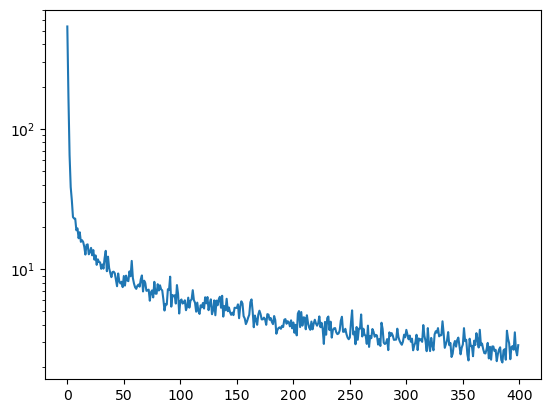

In [21]:


# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the learning rate
learning_rate = 1e-3

# Define the optimizer
optimizer = torch.optim.Adam(predictor.parameters(), lr=learning_rate)
predictor.train()
# Train the model
num_epochs = 400
pbar = tqdm(range(num_epochs))
losses=[]
for epoch in pbar:
    steps=0
    total_loss=0
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = predictor(X_batch)
        
        # Compute the loss
        loss = loss_fn(y_pred, y_batch)
        total_loss+=loss.item()
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        steps+=1
        # Update the progress bar
        pbar.set_postfix({'Loss': total_loss/steps})
    losses.append(total_loss/steps)
predictor.eval()
plt.plot(losses)
plt.yscale('log')



In [22]:
#evaluate the predictor
y_pred=predictor(X_val_tensor)
loss = loss_fn(y_pred, y_val_tensor)
print(f'Validation loss: {loss.item()}')

Validation loss: 7.825398921966553


## Train the two Neural Netwoks

100%|██████████| 10000/10000 [00:33<00:00, 296.15it/s, Loss_error=17.4, Loss_MSE=2.42]


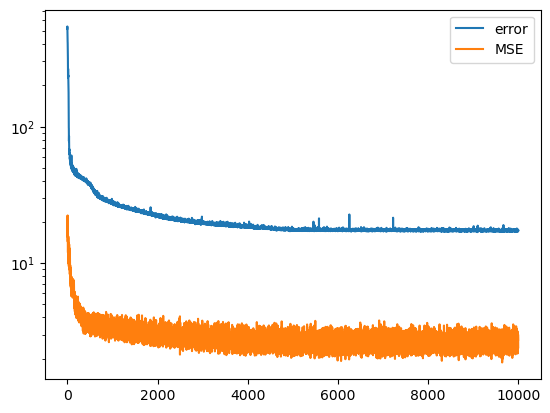

In [23]:
#freeze the feature map
for param in feature_map.parameters():
    param.requires_grad = False

# Define the loss function

def loss_error(coeffs_pred,error):
    return torch.sum(coeffs_pred**2*(error))
loss_fn = torch.nn.MSELoss()


#make a loader for the errors
model_pred=np.stack([m(X_val.to_numpy()) for m in models_reduced],axis=1)
errors = (y_val.to_numpy()[:,None]-model_pred)**2
errors_tensor=torch.tensor(errors,dtype=torch.float32)
model_pred_tensor=torch.tensor(model_pred,dtype=torch.float32)
y_train_tensor=torch.tensor(y_val.to_numpy(),dtype=torch.float32)
errors_data = torch.utils.data.TensorDataset(torch.tensor(X_val.to_numpy(),dtype=torch.float32),errors_tensor,y_val_tensor,model_pred_tensor)
errors_loader = torch.utils.data.DataLoader(errors_data, batch_size=32, shuffle=True)


# Define the learning rate
learning_rate = 1e-4

# Define the optimizers
optimizer_error = torch.optim.Adam(aggregator_error.parameters(), lr=learning_rate,weight_decay=1e-3)
aggregator_error.train()
optimizer_MSE = torch.optim.Adam(aggregator_MSE.parameters(), lr=learning_rate,weight_decay=1e-3)
aggregator_MSE.train()


# Train the model
num_epochs = 10000
pbar = tqdm(range(num_epochs))
losses=[]
for epoch in pbar:
    steps=0
    total_loss_error=0
    total_loss_MSE=0
    if epoch==num_epochs//2:
        for param in feature_map.parameters():
            param.requires_grad = False
        feature_map.train()
        #reinitialize the optimizer with very small learning rate
        optimizer_error = torch.optim.Adam(aggregator_error.parameters(), lr=learning_rate/20,weight_decay=1e-3)
        optimizer_MSE = torch.optim.Adam(aggregator_MSE.parameters(), lr=learning_rate/20,weight_decay=1e-3)
    for X,error_batch,y,model_pred_tensor in errors_loader:
        # Forward pass
        x=torch.cat([X,model_pred_tensor],dim=1)
        coeffs_pred_error = aggregator_error(x)
        coeffs_pred_MSE = aggregator_MSE(x)
        
        # Compute the loss
        loss_error_ = loss_error(coeffs_pred_error,error_batch)
        loss_MSE=loss_fn(y[:,0],torch.einsum('ij,ij->i',coeffs_pred_MSE,model_pred_tensor))
        total_loss_error+=loss_error_.item()
        total_loss_MSE+=loss_MSE.item()

        # Zero the gradients
        optimizer_error.zero_grad()
        optimizer_MSE.zero_grad()
        
        # Backward pass
        loss_error_.backward()
        loss_MSE.backward()
        
        # Update the parameters
        optimizer_error.step()
        optimizer_MSE.step()
        steps+=1
        # Update the progress bar
        pbar.set_postfix({'Loss_error': total_loss_error/steps,'Loss_MSE': total_loss_MSE/steps})
    losses.append((total_loss_error/steps,total_loss_MSE/steps))
aggregator_error.eval()
aggregator_MSE.eval()

plt.plot(losses)
plt.legend(['error','MSE'])
plt.yscale('log')
plt.show()


In [24]:
def compute_metrics(aggregator_,input_,model_pred_test):
    alpha_test=aggregator_(torch.tensor(input_,dtype=torch.float32)).detach().numpy()
    y_pred = np.einsum('ij,ij->i',alpha_test,model_pred_test)


    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae,mse,r2
model_pred_test=np.stack([m(X_test.to_numpy()) for m in models_reduced],axis=1)
# Store the performance metrics in the dictionary
performances['MEVA with DNN'] = list(compute_metrics(aggregator_error,np.concatenate([X_test.to_numpy(),model_pred_test],axis=1),model_pred_test))
performances['MEEA with DNN'] = list(compute_metrics(aggregator_MSE,np.concatenate([X_test.to_numpy(),model_pred_test],axis=1),model_pred_test))

# Visualize performances

In [25]:
performances

{'Linear Regression': [3.1811607520875405,
  17.038701324922055,
  0.7926083526613221],
 'Decision Tree': [3.811764705882353, 24.47176470588235, 0.7021345994125715],
 'Random Forest': [2.0707647058823526, 8.69406978431373, 0.8941775303022106],
 'Support Vector Regression': [2.9198113986438625,
  22.77654539717621,
  0.7227684680583386],
 'KNeighbors Regression': [2.851372549019608,
  15.426862745098042,
  0.8122273278366656],
 'Gradient Boosting Regression': [2.1418735792213686,
  9.806188789034088,
  0.8806410413393899],
 'mean': [2.1871302902155234, 10.036160528399728, 0.8778418715576753],
 'MEVA with kernel': [2.04847357762762, 8.873756340360123, 0.8919904216633281],
 'MEVA with DNN': [2.1661705219423193, 9.981640631511317, 0.8785054767827921],
 'MEEA with DNN': [2.513623158957815, 13.340938368683751, 0.8376167800254721]}

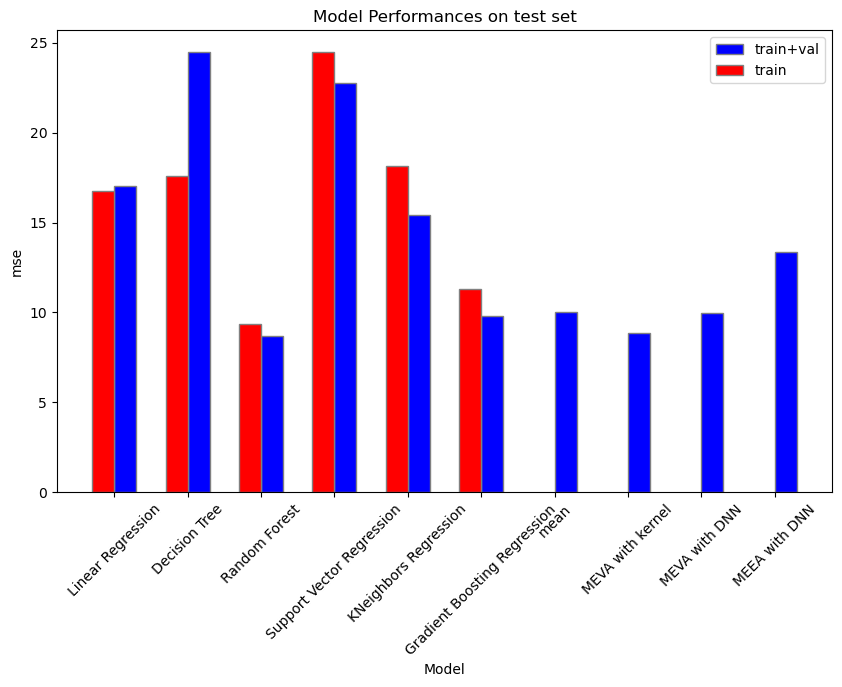

In [31]:
# Visualize the performances
#get two bars per model from performances and performances_reduced, except that the aggregation model is only in performances
plt.figure(figsize=(10, 6))
which_error=1
error_type=['mae','mse','r2']
barWidth = 0.3
bars1 = [p[which_error] for p in performances.values()]
bars2 = [p[which_error] for p in performances_reduced.values()]
r1 = np.arange(len(bars1))
r2 = [x - barWidth for x in r1[:-4]]
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='train+val')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='train')
plt.xlabel('Model')
plt.ylabel(f'{error_type[which_error]}')
plt.title('Model Performances on test set')
plt.xticks([r - barWidth/2 for r in range(len(bars1))], performances.keys(), rotation=45)

plt.legend()
plt.show()



# Let's visualize the aggregation for the different sets

You may change `train_or_test` to see the different sets possible and view how $\alpha$ evolves from input to input. 

In [27]:
train_or_test='test'
assert train_or_test in ['train','test','val']
if train_or_test=='train':
    X_train_or_test=X_train_reduced.to_numpy()
    y_train_or_test=y_train_reduced.to_numpy()
elif train_or_test=='test':
    X_train_or_test=X_test.to_numpy()
    y_train_or_test=y_test.to_numpy()
else:
    X_train_or_test=X_val.to_numpy()
    y_train_or_test=y_val.to_numpy()


In [28]:
diffs=[]
model_pred=[]
for model, name in zip(models_reduced, model_names):
    
    # Make predictions on the test set
    y_pred = model(X_train_or_test)
    model_pred.append(y_pred)
    diff=np.abs((y_pred-y_train_or_test))
    diffs.append(diff)
    
alpha = agg.coeff(X_train_or_test).T
model_pred=np.stack(model_pred,axis=0)
y_pred = np.einsum('ij,ij->j',alpha,model_pred)
diff=np.abs((y_pred-y_train_or_test))
diffs.append(diff)
diffs=np.stack(diffs,axis=0)

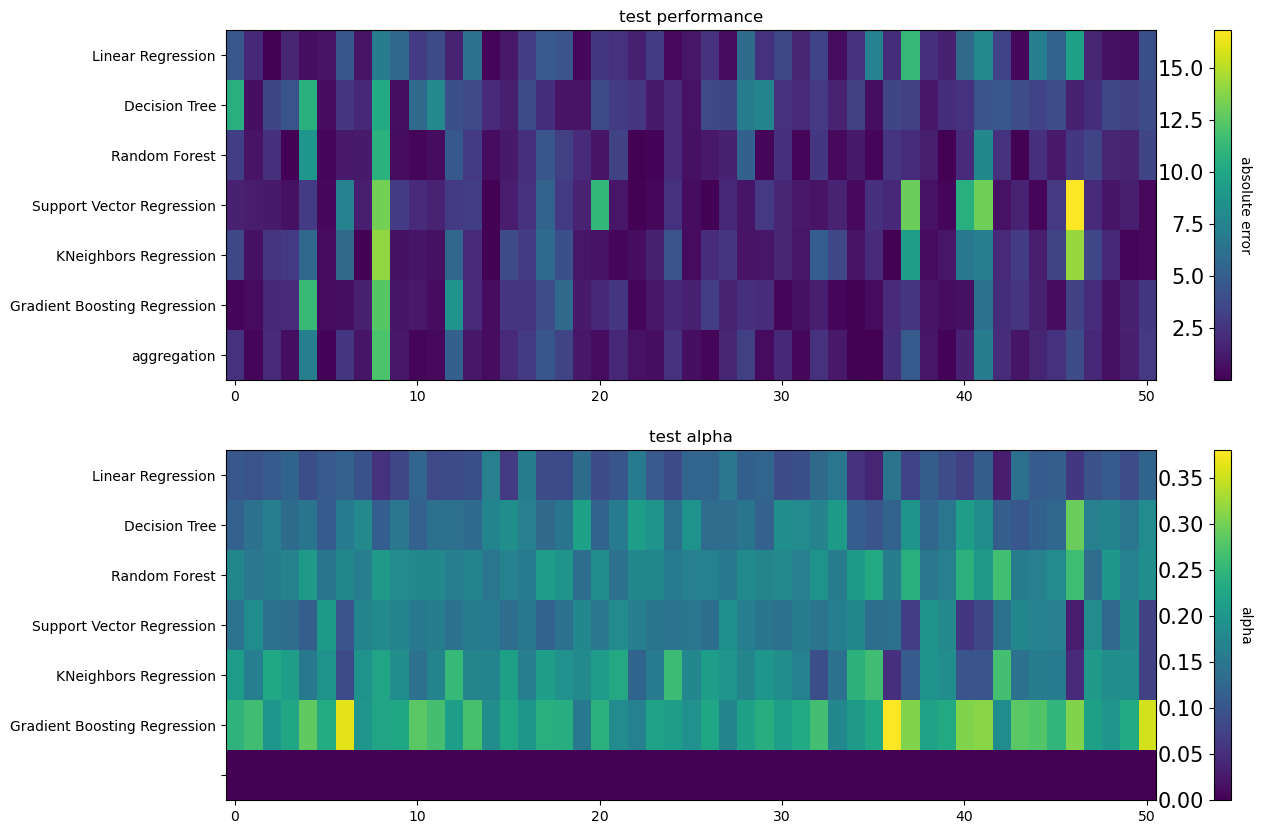

In [29]:

#change xticks labels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.imshow(np.abs(diffs), aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(np.abs(diffs), aspect='auto'))
cbar.ax.set_ylabel('absolute error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')
plt.show()